## Import Statements

In [1]:
import pandas as pd
import glob
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import softmax
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, recall_score, precision_score, accuracy_score
from sklearn import svm
import seaborn as sns
sns.set()
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

## Data Preprocessing

### Add binary column with -1, 0, 1

In [2]:
# Change number in binary column to a -1 every other 10 seconds
def controlCol(data):
    
    binary = data['binary']
    for i in range(0, len(binary)):
        test = i % 20
        if 0 <= test and test < 10:
            binary.loc[i] = -1
    data.loc['binary'] = binary    

#     print (binary)
    return data

### Reads and concatenates data

In [3]:
# Takes in experiment type(vi, to, tv) and object name
# Cold = 1
# Hot = 0

path = r'C:\\Users\\Cleah\\Documents\\A Tactile\\Data\\'

def concat_data(extype, obtype):
    #  Treats infinty values as NaN values
    pd.set_option('use_inf_as_na', True)
    # name of the data file
    fileName = glob.glob(path + "*\\" + extype + "-" + obtype + "*.csv")
#     print (fileName)
    # objectType is for instance hoco + ho
    objectType = obtype + obtype[0:2]
    # objectType2 is for instance hoco + co
    objectType2 = obtype + obtype[2:4]    
    
    totalRows = pd.read_csv(fileName[0])
    if objectType2 in fileName[0]:
        # add column of number 1
        totalRows['binary'] = 1
    else:
        # add column of number 0
        totalRows['binary'] = 0
    for i in range(1, len(fileName)):
        file = pd.read_csv(fileName[i])
        if objectType2 in fileName[i]:
            # add column of number 1
            file['binary'] = 1
        else:
            # add column of number 0
            file['binary'] = 0
        thisName = fileName[i]
        file['participant'] = thisName[-16]
        file = controlCol(file)
        totalRows = pd.concat([totalRows, file], axis = 0, ignore_index = True)
    
    totalRows = totalRows.drop(totalRows.columns[21:-2], axis = 1)
    # Remove electrode AF7
    totalRows = totalRows.drop(columns = ['Delta_AF7', 'Alpha_AF7', 'Gamma_AF7', 'Theta_AF7', 'Beta_AF7'], axis = 1)

    # Data Processing
    # deleting columns
#     totalRows = totalRows.drop(totalRows.columns[21:-2], axis = 1)
#     print(totalRows)
    # deleting rows
    totalRows.dropna(
       axis = 0,
       how = 'any',
       thresh = None,
       subset = None,
       inplace = True
     )
    totalRows = removeRows(totalRows)
    return totalRows

### Removes rows with 0 or -infinity

In [4]:
# This function removes rows with twenty zeros on them.
def removeRows(data):
    # Create a new DataFrame where each cell is True if zero and False otherwise
    zeros = data == 0
    # Create a new DataFrame where each row has a single cell containing number of zeros
    num_zeros = zeros.sum(axis = 1)  # Axis is 1 (rows = axis 0 and columns = axis 1) because we are producing sums of rows "along" axis 1
    
    # Create a new DataFrame where each row has a single cell that is True if there aren't 20 zeros and False otherwise
    keep_row = num_zeros != 20  # This creates a sort of "index" that tells us the indices of which rows to keep
    
    # Select the rows to keep from our input DataFrame (called df) using the indices of rows to keep that are stored in keep_row
    return data[keep_row]

### Data Processing File

In [27]:
data = concat_data("tv", "drwe")
data = data.reset_index()
data.to_csv('test.csv', index = False)
shape = data.shape
print(data)

C:\Users\Cleah\anaconda3\envs\pt-project\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


     index                TimeStamp  Delta_TP9  Delta_AF8  Delta_TP10  \
0      130  2020-11-26 12:21:46.983   1.807652   1.003191    0.273898   
1      133  2020-11-26 12:21:47.977   1.807652   1.437529    0.273898   
2      134  2020-11-26 12:21:48.977   1.807652   0.524038    0.273898   
3      137  2020-11-26 12:21:49.978   1.807652   1.525835    0.273898   
4      140  2020-11-26 12:21:50.978   1.807652   1.896392    0.273898   
..     ...                      ...        ...        ...         ...   
579    850  2020-12-19 16:13:10.966   0.918895   0.427594    1.510115   
580    851  2020-12-19 16:13:11.967   0.904963   0.207812    0.930535   
581    852  2020-12-19 16:13:12.966   0.458401  -0.145021    0.410244   
582    854  2020-12-19 16:13:13.971   0.068870   0.077642    0.188752   
583    855  2020-12-19 16:13:14.966   0.564199   0.353301    0.984290   

     Theta_TP9  Theta_AF8  Theta_TP10  Alpha_TP9  Alpha_AF8  Alpha_TP10  \
0     1.079689   0.685991    0.985595   1.027286

### Data Preparation

In [33]:
# In this cell, x and y are put in numpy arrays.
# Basic logistic regression model is made with 85% accuracy.
# All the data is used.


# Convert dataframe to numpy array
x = data[data.columns[2:-2]].to_numpy()
y = data[data.columns[-2]].to_numpy()
print (data.columns[0])
xOrig = x 
yOrig = y
# dataOrig has 1, -1, 0
dataOrig = data
# data has 1, 0
data = data[data['binary'] != -1]
x = x[y != -1,:] 
y = y[y != -1]
# Normalize Data
scalerX = StandardScaler()
X = scalerX.fit_transform(x)
scalerX = StandardScaler()
xOrig = scalerX.fit_transform(xOrig)

index


## Conditional Variational Auto-Encoder

### Torch Tensor

In [37]:
# Torch Tensor
# X is frequency bands
#X.to_numpy()
X = x
X = torch.tensor(X)
# y is the binary column
y = dataOrig['binary']
y = y.to_numpy()
y = torch.tensor(y, dtype = torch.int64)

#### Tensor Dataset

In [38]:
# Tensor
dataset = TensorDataset(X, y)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = 20,shuffle = True, num_workers = 2)
for epoch in range(2):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients

### CVAE Object

In [39]:
def onehot(label, numlabels):
  r""" One hot encodes given tensor
  :param label: zero-indexed labels of data (must be tensor)
  :param numlabels: total number of labels possible
  :return: onehot tensor encoding
  """
  if label.dim() == 1:
      label = label.unsqueeze(1)
  onehot = torch.zeros(label.size(0), numlabels)
  onehot.scatter_(1, label, 1)
  
  return onehot
print(onehot(torch.tensor([1,2,3,1]),10)) # Run to understand what code doing

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [42]:
class Encoder(nn.Module):
  def __init__(self, layers, hidden, numlabels):
    r""" Initializes and encoder model with following parameters
    :param layers: an array/list where the ith element is the number of neurons to put in the ith layer [the first layer is the input layer]
    :param hidden: size of hidden space
    :param numlabels: number of labels to use
    """
    super().__init__() # This line just tells nn.Module to do what it needs to do to get things ready for us to use
    if len(layers) < 1:
      raise ValueError('No layers specified')
    layers[0] += numlabels # In a CVAE, we will input both the data (the EEG) and the label (a one-hot encoding)

    self.net = nn.Sequential() # Sequential will let us add any number of layers and net will hold this network that we use.
    self.numlabels = numlabels 

    for i in range(len(layers)-1):
      # Add network layer
      self.net.add_module(
          name = f"Layer {i + 1}", # 1-indexed layer name
          module = nn.Linear(layers[i], layers[i+1]) # fully connected "normal" network layer with given input and output size
      )
      # Add nonlinear function
      self.net.add_module(
          name = f"Activation {i+1}", 
          module = nn.ReLU() # relu activation function for nonlinearity
      )

    # So far, we've transformed our data. We want to produce a "latent"/"hidden" representation of our data.
    # Importantly, we want to find the mean and standard deviation of such a distribution, becuase then we can 
    # randomly sample from this distribution.
    self.meanlayer = nn.Linear(layers[-1], hidden) # generates layer for mean with last (layers[-1]) number to hidden size
    self.logvarlayer = nn.Linear(layers[-1], hidden)

  def forward(self, x, label):
    r""" Computes prediction of this model.
    :param x: input tensor data with shape (batch_size, dim1, dim2, etc.)
    :param label: label to use
    """
    label = onehot(label, self.numlabels) # Will convert to a vector
    x = torch.cat((x, label.to(dtype=torch.float)), dim = -1) # Add label to input data
    x = self.net(x.float()) # Runs input through model
    mean = self.meanlayer(x) # Finds mean of latent space predicted
    logvar = self.logvarlayer(x) # Finds log variance of latent space predicted

    return mean, logvar    

In [43]:
class Decoder(nn.Module):
  def __init__(self, layers, hidden, numlabels):
    r""" Initializes and encoder model with following parameters
    :param layers: an array/list where the ith element is the number of neurons to put in the ith layer [the first layer is the input layer]
    :param hidden: size of hidden space
    :param numlabels: number of labels to use
    """
    super().__init__() # This line just tells nn.Module to do what it needs to do to get things ready for us to use
    if len(layers) < 1:
      raise ValueError('No layers specified')
    
    inputsize = numlabels + hidden # we will be inputting our onehot encoding + the encoder output (hidden size)

    self.net = nn.Sequential() # Sequential will let us add any number of layers and net will hold this network that we use.
    self.numlabels = numlabels

    # Add layer for input coming in
    self.net.add_module(
        name = f"Layer {0}", # 1-indexed layer name
        module = nn.Linear(inputsize, layers[0]) # fully connected "normal" network layer with given input and output size
    )
    # Add nonlinear function
    self.net.add_module(
        name = f"Activation {0}", 
        module = nn.ReLU() # relu activation function for nonlinearity
    )

    for i in range(len(layers)-1):
      # Add network layer
      self.net.add_module(
          name = f"Layer {i + 1}", # 1-indexed layer name
          module = nn.Linear(layers[i], layers[i+1]) # fully connected "normal" network layer with given input and output size
      )
      # Add nonlinear function
      if i < len(layers) - 2:
        self.net.add_module(
            name = f"Activation {i+1}", 
            module = nn.ReLU() # relu activation function for nonlinearity
        )
#       else:
#         self.net.add_module(
#             name = f"Actifvation {i+1} (sigmoid)", 
#             module = nn.Sigmoid()
#         )

  def forward(self, x, label):
    r""" Computes prediction of this model.
    :param x: input tensor data with shape (batch_size, dim1, dim2, etc.)
    :param label: label to use
    """
    label = onehot(label, self.numlabels) # Will convert to a vector
    x = torch.cat((x, label), dim=-1) # Add label to input data
    z = self.net(x) # Runs input through model
    # mean = self.meanlayer(x) # Finds mean of latent space predicted
    # logvar = self.logvarlayer(x) # Finds log variance of latent space predicted

    return z   

In [44]:
# Put encoder and decoder together
class CVAE(nn.Module):
  def __init__(self, enclayers, hidden, declayers, numlabels):
    r""" Creates wrapper class.
    :param enclayers: layers to pass into Encoder
    :param hidden: number of neurons in hidden layer
    :param declayers: layers to pass into Decoder
    :param numlabels: total number of lables
    """
    super().__init__()
    # Defining fields to store.
    self.hidden = hidden
    self.encoder = Encoder(
        layers = enclayers,
        hidden = hidden,
        numlabels = numlabels
    )
    self.decoder = Decoder (
        layers = declayers,
        hidden = hidden,
        numlabels = numlabels
    )

  def forward(self, x, label):
    r""" Runs through encoder and decoder (only useful for training)
    :param x: input data with traditional pytorch size
    :param label: label number [zero indexed] in tensor
    """
    mean, logvar = self.encoder(x, label) # Get distribution
    sample = self.sample(mean,logvar) # Get sample from distribution
    reconstructed = self.decoder(sample, label) # Get reconstruction with decoder
    return reconstructed, mean, logvar, sample

  def predict(self, label):
    r""" Generates data associated with given label
    :param label: label with same notation as previously (should be a tensor)
    :return: data with same size as training inputs
    """
    sample = torch.randn([label.size(0), self.hidden])
    return self.decoder(sample, label)

  def sample(self, mean, logvar):
    r""" Draws from normal distribution with given parameters.
    :param mean: mean of distribution
    :param logvar: log of variance
    :return: random sample
    """
    std = torch.exp(0.5 * logvar)
    randnums = torch.randn_like(std)
    return mean + randnums * std


In [45]:
model = CVAE([3,5,2], 2, [2,3,5], 10)
print(model.forward(torch.unsqueeze(torch.tensor([1,2,3]),0),torch.tensor([1])))

(tensor([[ 0.4753,  0.6914, -0.1110,  0.1341, -0.1254]],
       grad_fn=<AddmmBackward>), tensor([[-0.4875, -0.4193]], grad_fn=<AddmmBackward>), tensor([[ 0.4004, -0.3288]], grad_fn=<AddmmBackward>), tensor([[-2.0720,  0.2759]], grad_fn=<AddBackward0>))


In [46]:
def loss_fn(reconstructed, x, mean, logvar):
  r""" Computes loss of VAE output.
  :param reconstructed: what the VAE said
  :param x: what the inputs were
  :param mean: what the VAE found hte mean was
  :param logvar: what hte VAE found the logvar to be
  :return: the loss
  """
  bce = torch.nn.functional.mse_loss(reconstructed.view(-1,15), x.float().view(-1,15)) # TODO: change 15 to number of features :)
  kld = -0.5 * torch.sum(1+logvar-mean.pow(2)-logvar.exp())
  return (bce + kld)/x.size(0)

### Train CVAE

In [47]:
# Creating an object
net = CVAE([15, 10, 5], 8, [5, 10, 15], 2)
# Creating an optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.4)

losses = []
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        reconstructed, mean, logvar, sample = net(inputs, labels)
        loss = loss_fn(reconstructed, inputs, mean, logvar)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            losses.append(running_loss/10)
            running_loss = 0.0
  
print('Finished Training')

C:\Users\Cleah\anaconda3\envs\pt-project\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[1,    10] loss: 0.333
[2,    10] loss: 0.183
[3,    10] loss: 0.124
[4,    10] loss: 0.096
[5,    10] loss: 0.078
[6,    10] loss: 0.067
[7,    10] loss: 0.059
[8,    10] loss: 0.052
[9,    10] loss: 0.050
[10,    10] loss: 0.047
[11,    10] loss: 0.044
[12,    10] loss: 0.042
[13,    10] loss: 0.041
[14,    10] loss: 0.040
[15,    10] loss: 0.039
[16,    10] loss: 0.039
[17,    10] loss: 0.038
[18,    10] loss: 0.038
[19,    10] loss: 0.036
[20,    10] loss: 0.034
Finished Training


### Test CVAE

#### Loss Curve

(20,)


Text(0, 0.5, 'Loss')

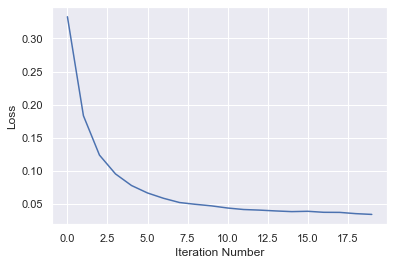

In [48]:
# Loss Curve
loss = np.array(losses)
print(np.array(losses).shape)
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration Number')
plt.ylabel('Loss')

#### Multi-Layer Perceptron

##### Training ---> Real Data & Testing ---> Real Data

C:\Users\Cleah\anaconda3\envs\pt-project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[[14 12]
 [ 8 21]]


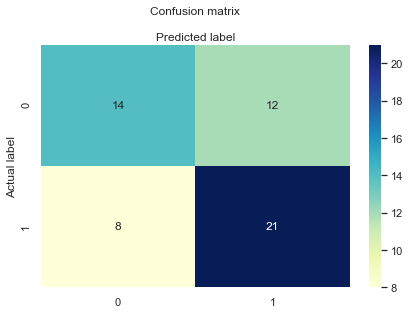

In [49]:
# Multiple Layer Perceptron
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size = 0.20, random_state = 42)
multilper = MLPClassifier(random_state = 1, max_iter = 300, hidden_layer_sizes = (100, 100)).fit(X_train, y_train)
y_pred = multilper.predict(X_test)
multilper.score(X_test, y_test)

# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
class_names = [1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu', fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


##### Training ---> CVAE Data & Testing ---> Real Data

[[114  12]
 [137  10]]


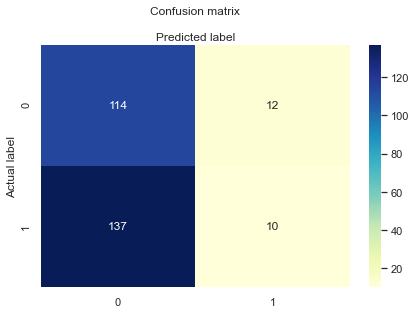

In [50]:
# Make a tensor of 0s and 1s for hot/cold
num_examples = 500
labels_test = torch.zeros(num_examples, dtype = torch.int64)
labels_test[0:int(num_examples / 2)] = 1

# Get trained CVAE's predicted EEG for those labels using the predict function
predictCVAE = net.predict(labels_test)

# Convert EEG to numpy using .numpy() and feed into multilper.predict
predictCVAE = predictCVAE.detach().numpy()
predictMLP = multilper.predict(predictCVAE)

# Multi-layer perceptron for the CVAE output
multilper = MLPClassifier(random_state = 1, max_iter = 300, hidden_layer_sizes = (100, 100)).fit(predictCVAE, labels_test)
y_pred1 = multilper.predict(X)
multilper.score(X_test, y_test)

# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y, y_pred1)
print(cnf_matrix)
class_names = [1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu', fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Score original labels with multilper.predict


###### Confusion Matrix

[[  0 250]
 [  2 248]]


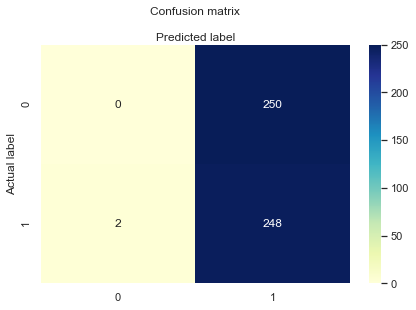

In [51]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(labels_test, predictMLP)
print(cnf_matrix)
class_names = [1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu', fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Logistic Regression

In [52]:
# Split data into 80% Training and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size = 0.20, random_state = 42)
logReg2 = LogisticRegression(random_state = 0)
logReg2 = logReg2.fit(X, y)
y_predLR = logReg2.predict(predictCVAE)
# Model Accuracy
accuracy = metrics.accuracy_score(labels_test, y_predLR)
print("Accuracy: ", accuracy)

Accuracy:  0.5


##### Confusion Matrix

[[249   1]
 [249   1]]


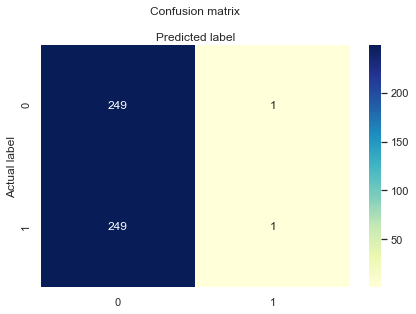

In [53]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(labels_test, y_predLR)
print(cnf_matrix)
class_names = [1,2,3,4,5]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu', fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()